In [65]:
ALGORITHM = 'Linear Regression'
ALGORITHM_DETAIL = 'random search'
VERSION = '03'

RANDOM_STATE = 101
TRAINING_SIZE = 0.9

CROSS_VALIDATION_SCORING = 'r2'

In [66]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import Lasso, Ridge

pipe = Pipeline([
    #('mms', MinMaxScaler()),
    ('std_scaler', StandardScaler()),
    ('model', Ridge())
])

In [67]:
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np
from pandas import DataFrame
import math
from termcolor import colored

confirm_colab = False

try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = confirm_colab

if not IN_COLAB:
    from functions_20221018 import set_csv_directory, get_combined_dataset, add_supplements, tidy_dataset, feature_engineer

set_csv_directory('final_split')

debug_mode = False

In [68]:
#cutdown_rows = 1000
cutdown_rows = 0

LABEL = 'Price'

booleans = []
floats = ['location.latitude', 'location.longitude', 'bedrooms', 'bathrooms', 'nearestStation', 'latitude_deviation',
          'latitude_deviation2', 'longitude_deviation', 'longitude_deviation2']
floats = ['bedrooms', 'bathrooms', 'nearestStation', 'latitude_deviation2', 'longitude_deviation2']
categories = ['tenure.tenureType']

columns = []
columns.extend(booleans)
columns.extend(floats)
columns.extend(categories)

print(colored(f"features", "blue"), "-> ", columns)
columns.insert(0, LABEL)
print(colored(f"label", "green", None, ['bold']), "-> ", LABEL)

features ->  ['bedrooms', 'bathrooms', 'nearestStation', 'latitude_deviation2', 'longitude_deviation2', 'tenure.tenureType']
label ->  Price


In [69]:
filename = f'df_listings_v{VERSION}.csv'
remote_pathname = f'https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/{filename}'
df_pathname_raw = f'../../data/source/{filename}'
df_pathname_tidy = f'../../data/final/{filename}'


def get_source_dataframe(rows=cutdown_rows, folder_prefix='../'):
    retrieval_type = None

    if IN_COLAB:
        inDF = pd.read_csv(remote_pathname, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', remote_pathname)
    else:
        try:
            inDF = pd.read_csv(df_pathname_tidy, on_bad_lines='error', index_col=0)
            retrieval_type = 'tidy'
            print('loaded data from', df_pathname_tidy)
        except:
            try:
                inDF = pd.read_csv(df_pathname_raw, on_bad_lines='error', index_col=0)
                retrieval_type = 'raw'
                print(f'starting to get {retrieval_type} data...')
                print('loaded data from', df_pathname_raw)
                print(f'finished getting {retrieval_type} data!')
            except:
                print(f"WARNING: Failed to retrieved stored data for version {VERSION}, creating new source data.")
                retrieval_type = 'scratch'
                print(f'starting to get {retrieval_type} data...')
                inDF = get_combined_dataset(HOW='inner', early_duplicates=True, folder_prefix=folder_prefix)
                print(f'finished getting {retrieval_type} data!')

                print(f'starting to save {retrieval_type} data...')
                inDF.to_csv(df_pathname_raw)
                print(f'finished saving {retrieval_type} data!')

    if rows and rows > 0:
        inDF = inDF[:rows]
    return inDF, retrieval_type


def create_train_test_data(df_orig, return_index=False, drop_nulls=True):
    df = df_orig.copy()

    if drop_nulls:
        df.dropna(inplace=True)

    if return_index:
        df.reset_index(inplace=True)

    for column in categories:
        df = pd.concat([df, pd.get_dummies(df[column], prefix=column)], axis=1)
        df.drop([column], axis=1, inplace=True)  # now drop the original column (you don't need it anymore),

    ins = df.pop('index')
    df.insert(1, 'index2', ins)
    df.insert(0, 'index', ins)

    #features = df[df.columns[1:]].values
    features = df[df.columns[2:]].values
    #labels = df[LABEL].values
    labels = df.iloc[:, 0:2].values

    if not return_index:
        return train_test_split(features, labels, train_size=0.9, random_state=RANDOM_STATE)
    else:
        X_train1, X_test1, y_train1, y_test1 = train_test_split(features, labels, train_size=0.9,
                                                                random_state=RANDOM_STATE)
        X_train_index = X_train1[:, 0].reshape(-1, 1)
        y_train_index = y_train1[:, 0].reshape(-1, 1)
        X_test_index = X_test1[:, 0].reshape(-1, 1)
        y_test_index = y_test1[:, 0].reshape(-1, 1)
        X_train1 = X_train1[:, 1:]
        y_train1 = y_train1[:, 1].reshape(-1, 1)
        X_test1 = X_test1[:, 1:]
        y_test1 = y_test1[:, 1].reshape(-1, 1)

        return X_train1, X_test1, y_train1, y_test1, X_train_index, X_test_index, y_train_index, y_test_index

#X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index = create_train_test_data(get_source_dataframe(), return_index=True, drop_nulls=False)
#X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape, y_train_index.shape, y_test_index.shape,

In [70]:
df, retrieval_type = get_source_dataframe(folder_prefix='../../')
df_orig = df.copy()

if retrieval_type != 'tidy':
    if retrieval_type != 'raw':
        df = add_supplements(df)
        print(f'starting to save {retrieval_type} data...')
        df.to_csv(df_pathname_raw)
        print(f'finished saving {retrieval_type} data!')
    df = tidy_dataset(df, version=int(VERSION))
    df = feature_engineer(df, version=int(VERSION))

    df = df[columns]

    print(f'starting to save {retrieval_type} data...')
    df.to_csv(df_pathname_tidy)
    print(f'finished saving {retrieval_type} data!')

print(df.shape)
df[:5]

df_orig.merge(df, how='inner', left_index=True, right_index=True)

print(df.index)

loaded data from ../../data/final/df_listings_v03.csv
(51963, 11)
Int64Index([ 14520525,  27953107,  33593487,  35271294,  35429088,  44749111,
             46204665,  49020666,  49036279,  49303873,
            ...
            126173423, 126173600, 126175973, 126178769, 126179018, 126179672,
            126180107, 126180704, 126180962, 126181118],
           dtype='int64', length=51963)


In [71]:
df

,Price,location.latitude,location.longitude,bedrooms,bathrooms,nearestStation,latitude_deviation,latitude_deviation2,longitude_deviation,longitude_deviation2,tenure.tenureType
14520525,550000.0,51.529950,-0.207020,3.0,1.0,0.274316,0.030298,0.067288,0.102580,0.141915,LEASEHOLD
27953107,400000.0,51.549390,-0.482600,2.0,2.0,0.305845,0.049738,0.086728,0.378160,0.417495,LEASEHOLD
33593487,579950.0,51.447180,-0.338770,2.0,1.0,0.438045,0.052472,0.015482,0.234330,0.273665,FREEHOLD
35271294,370000.0,51.449568,-0.140154,2.0,1.0,0.399307,0.050084,0.013094,0.035714,0.075049,LEASEHOLD
35429088,599950.0,51.577030,-0.141230,2.0,1.0,0.238187,0.077378,0.114368,0.036790,0.076125,NaN
...,...,...,...,...,...,...,...,...,...,...,...
126179672,600000.0,51.357170,-0.074740,3.0,2.0,0.545665,0.142482,0.105492,0.029700,0.009635,LEASEHOLD
126180107,419999.0,51.531415,-0.052964,2.0,1.0,0.191407,0.031763,0.068753,0.051476,0.012141,LEASEHOLD
126180704,475000.0,51.543141,0.011498,2.0,1.0,0.308609,0.043489,0.080479,0.115938,0.076603,LEASEHOLD
126180962,450000.0,51.592105,-0.008233,NaN,1.0,0.476935,0.092453,0.129443,0.096207,0.056872,FREEHOLD


In [72]:
df.isnull().sum()

Price                      0
location.latitude         10
location.longitude         0
bedrooms                1742
bathrooms               3167
nearestStation             0
latitude_deviation        10
latitude_deviation2       10
longitude_deviation        0
longitude_deviation2       0
tenure.tenureType       3381
dtype: int64

In [73]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51963 entries, 14520525 to 126181118
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Price                 51963 non-null  float64
 1   location.latitude     51953 non-null  float64
 2   location.longitude    51963 non-null  float64
 3   bedrooms              50221 non-null  float64
 4   bathrooms             48796 non-null  float64
 5   nearestStation        51963 non-null  float64
 6   latitude_deviation    51953 non-null  float64
 7   latitude_deviation2   51953 non-null  float64
 8   longitude_deviation   51963 non-null  float64
 9   longitude_deviation2  51963 non-null  float64
 10  tenure.tenureType     48582 non-null  object 
dtypes: float64(10), object(1)
memory usage: 6.8+ MB


,Price,location.latitude,location.longitude,bedrooms,bathrooms,nearestStation,latitude_deviation,latitude_deviation2,longitude_deviation,longitude_deviation2
count,51963.000000,51953.000000,51963.000000,50221.000000,48796.000000,51963.000000,51953.000000,5.195300e+04,51963.000000,5.196300e+04
mean,420261.551950,51.496660,-0.104721,11.752414,1.177166,0.445197,0.063450,6.949965e-02,0.134302,1.389384e-01
std,110006.618045,0.076422,0.732518,2186.510990,0.410474,1.066998,0.042701,4.654016e-02,0.720101,7.203106e-01
min,100000.000000,51.298317,-0.498315,1.000000,1.000000,0.000000,0.000000,4.000000e-07,0.000000,2.000000e-07
25%,330000.000000,51.439677,-0.211772,1.000000,1.000000,0.224388,0.027740,3.115560e-02,0.044222,4.649980e-02
50%,425000.000000,51.499652,-0.104440,2.000000,1.000000,0.364267,0.057224,6.372140e-02,0.099000,1.031582e-01
75%,500000.000000,51.554580,-0.011463,3.000000,1.000000,0.557841,0.093732,1.009776e-01,0.192605,1.974192e-01
max,600000.000000,51.683185,51.558746,490000.000000,12.000000,192.431869,0.201335,2.205226e-01,51.663186,5.162385e+01


In [74]:
old_length = len(df)
df['location.latitude'] = pd.to_numeric(df['location.latitude'], 'coerce').dropna().astype(float)
df = df[(df['location.longitude'] <= 10)]
df = df[(df['longitude_deviation'] <= 1)]
df = df[(df['longitude_deviation2'] <= 1)]
df = df[(df['bedrooms'] <= 10)]
df = df[df['bathrooms'] <= 5]
df = df[(df['nearestStation'] <= 20)]

print(f"dataframe contract due to cleaning: {old_length} ==> {len(df)}")
old_length = len(df)

df.describe().T

dataframe contract due to cleaning: 51963 ==> 47296


,count,mean,std,min,25%,50%,75%,max
Price,47296.0,424469.678599,107681.003293,1.000000e+05,345000.000000,425000.000000,515000.000000,600000.000000
location.latitude,47296.0,51.496955,0.077080,5.129832e+01,51.438664,51.499887,51.556007,51.683185
location.longitude,47296.0,-0.113224,0.156355,-4.983150e-01,-0.210739,-0.102282,-0.010379,0.279726
bedrooms,47296.0,1.991373,0.828635,1.000000e+00,1.000000,2.000000,3.000000,7.000000
bathrooms,47296.0,1.182172,0.410106,1.000000e+00,1.000000,1.000000,1.000000,5.000000
nearestStation,47296.0,0.439735,0.350406,0.000000e+00,0.226653,0.367761,0.559066,16.168861
latitude_deviation,47296.0,0.064304,0.042586,0.000000e+00,0.028809,0.058585,0.094405,0.201335
latitude_deviation2,47296.0,0.070161,0.046847,4.000000e-07,0.031478,0.064619,0.101836,0.220523
longitude_deviation,47296.0,0.124088,0.095529,0.000000e+00,0.043521,0.098960,0.192495,0.393875
longitude_deviation2,47296.0,0.128341,0.101443,2.000000e-07,0.045573,0.102343,0.196653,0.433210


In [75]:
df.isna().sum()

Price                      0
location.latitude          0
location.longitude         0
bedrooms                   0
bathrooms                  0
nearestStation             0
latitude_deviation         0
latitude_deviation2        0
longitude_deviation        0
longitude_deviation2       0
tenure.tenureType       2760
dtype: int64

In [76]:
df = df.dropna()
print(f"{old_length} ==> {len(df)}")
old_length = len(df)
df.describe()

47296 ==> 44536


,Price,location.latitude,location.longitude,bedrooms,bathrooms,nearestStation,latitude_deviation,latitude_deviation2,longitude_deviation,longitude_deviation2
count,44536.000000,44536.000000,44536.000000,44536.000000,44536.000000,44536.000000,44536.000000,4.453600e+04,44536.000000,4.453600e+04
mean,424609.250898,51.496603,-0.113049,1.990053,1.181449,0.439503,0.064529,7.006823e-02,0.123587,1.278087e-01
std,107654.185067,0.077262,0.155732,0.827432,0.409188,0.350229,0.042599,4.702881e-02,0.095144,1.010732e-01
min,100000.000000,51.298317,-0.498315,1.000000,1.000000,0.000000,0.000000,4.000000e-07,0.000000,2.000000e-07
25%,345000.000000,51.438160,-0.210552,1.000000,1.000000,0.227205,0.028975,3.108160e-02,0.043483,4.530595e-02
50%,425000.000000,51.498676,-0.101931,2.000000,1.000000,0.368114,0.058904,6.442100e-02,0.098666,1.019750e-01
75%,515000.000000,51.556100,-0.010872,3.000000,1.000000,0.558861,0.094644,1.018984e-01,0.191621,1.957660e-01
max,600000.000000,51.683185,0.279726,7.000000,5.000000,16.168861,0.201335,2.205226e-01,0.393875,4.332102e-01


In [77]:
X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index = create_train_test_data(df,
                                                                                                                    return_index=True,
                                                                                                                    drop_nulls=True)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape,
      y_train_index.shape, y_test_index.shape)
#print(type(X_train))
#X_train[0]

(40082, 13) (4454, 13) (40082, 1) (4454, 1) (40082, 1) (4454, 1) (40082, 1) (4454, 1)


In [78]:
#imputer = SimpleImputer(strategy='mean')
#imputer.fit(X_train[6])
#X_train[6] = imputer.transform(X_train[6])

In [79]:
from time import time

pipe.fit(X_train, y_train)

model = Ridge()
model.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': 'deprecated',
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [80]:

from sklearn.pipeline import Pipeline

# Best Score:  0.30582573121661794
# Best Score:  {'alpha': 10, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'selection': 'cyclic', 'tol': 0.001, 'warm_start': True}
# Best Score:  Lasso(alpha=10, tol=0.001, warm_start=True)
# Best Score:  138

# find optimal alpha with grid search
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
#alpha = [1, 10, 100]
fit_intercept = [True, False]
max_iter = [100, 1000, 10000]
positive = [True, False]
solver = ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']
tol = [0.00001, 0.0001, 0.001, 0.01]
warm_start = [True, False]
# ['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'positive', 'precompute', 'random_state', 'selection', 'tol', 'warm_start'].

options__n_neighbours = [3, 5, 7, 9, 15, 31]
options__leafsize = [2, 3, 4, 57, 9, 13, 21]

param_grid = dict(model__alpha=alpha, model__fit_intercept=fit_intercept, model__max_iter=max_iter,
                  model__positive=positive,
                  model__tol=tol, model__solver=solver)
#param_grid = dict(estimator__n_neighbors=options__n_neighbours, estimator__leaf_size= options__leafsize)

#param_grid = {'model__n_neighbors': options__n_neighbours,'model__leaf_size': options__leafsize},
#param_grid = {'n_neighbors': options__n_neighbours,                   'leaf_size': options__leafsize},
cv = 2
n_jobs = 1
verbose = 1
refit = True

#grid = RandomizedSearchCV(estimator=model, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)

gs = RandomizedSearchCV(pipe, param_grid, cv=cv, n_jobs=n_jobs,
                        verbose=verbose, scoring=CROSS_VALIDATION_SCORING, refit=refit,
                        return_train_score=True),
gs

grid_result = gs[0].fit(X_train, y_train)


Fitting 2 folds for each of 10 candidates, totalling 20 fits


/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
6 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/guava/PycharmProjects/capstone_strea

In [81]:
pipe = grid_result.best_estimator_
timings = []

t0 = time()
pipe.fit(X_train, y_train)
timings.append(time() - t0)

print(timings)
average_time = sum(timings) / len(timings)
print(average_time)

[0.0567471981048584]
0.0567471981048584


In [82]:
def print_results(results):
    print(f'BEST PARAMS: {results.best_params_}')

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print(f'{round(mean, 3)} (+/-{round(std * 2, 3)}) for {params}')


print_results(grid_result)
print('Best Index: ', grid_result.best_index_)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
#print('Best Model: ', grid_result.)
#print('Best Params: ', grid_result.best_params_)[out]
### Best Score:  0.4883436188936269
### Best Params:  {'alpha': 0.01}


BEST PARAMS: {'model__tol': 0.01, 'model__solver': 'auto', 'model__positive': False, 'model__max_iter': 1000, 'model__fit_intercept': True, 'model__alpha': 1}
0.452 (+/-0.01) for {'model__tol': 1e-05, 'model__solver': 'sparse_cg', 'model__positive': False, 'model__max_iter': 1000, 'model__fit_intercept': True, 'model__alpha': 0.1}
-15.039 (+/-0.173) for {'model__tol': 1e-05, 'model__solver': 'lsqr', 'model__positive': False, 'model__max_iter': 10000, 'model__fit_intercept': False, 'model__alpha': 100}
-15.039 (+/-0.18) for {'model__tol': 1e-05, 'model__solver': 'lsqr', 'model__positive': False, 'model__max_iter': 10000, 'model__fit_intercept': False, 'model__alpha': 0.01}
0.452 (+/-0.01) for {'model__tol': 0.01, 'model__solver': 'auto', 'model__positive': False, 'model__max_iter': 1000, 'model__fit_intercept': True, 'model__alpha': 1}
-15.039 (+/-0.18) for {'model__tol': 0.001, 'model__solver': 'svd', 'model__positive': False, 'model__max_iter': 100, 'model__fit_intercept': False, 'mod

In [83]:
y_pred = pipe.predict(X_test)

In [84]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

y_pred = y_pred.reshape((-1, 1))

R2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print('-' * 10 + ALGORITHM + '-' * 10)
print('R square Accuracy', R2)
print('Mean Absolute Error Accuracy', MAE)
print('Mean Squared Error Accuracy', MSE)
print('Root Mean Squared Error', RMSE)

----------Linear Regression----------
R square Accuracy 0.4383177683788616
Mean Absolute Error Accuracy 64693.873773454216
Mean Squared Error Accuracy 6344423918.004436
Root Mean Squared Error 79651.89211816902


In [85]:
if debug_mode:
    print(y_test_index.reshape((-1, 1)).shape);
    print(y_pred.reshape((-1, 1)).shape);
    print(y_test.shape);
    print(y_test_index.shape);
    print(y_pred.shape);
    print(y_test.shape)

In [86]:
compare = np.hstack((y_test_index, y_test, y_pred))
compare_df = DataFrame(compare, columns=['reference', 'actual', 'predicted'])
compare_df['difference'] = abs(compare_df['actual'] - compare_df['predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100
compare_df['reference'] = compare_df['reference'].astype(str)
compare_df.set_index('reference', inplace=True)
compare_df

,actual,predicted,difference,diff 1 %,diff 2 %
reference,,,,,
120812111.0,450000.0,465858.703488,15858.703488,3.524156,3.404187
120616928.0,495000.0,527312.417497,32312.417497,6.527761,6.127756
121429886.0,420000.0,422745.005575,2745.005575,0.653573,0.649329
121087214.0,285000.0,389107.080028,104107.080028,36.528800,26.755381
125329820.0,275000.0,371790.544735,96790.544735,35.196562,26.033622
...,...,...,...,...,...
115698140.0,500000.0,641400.908561,141400.908561,28.280182,22.045636
116935787.0,200000.0,364620.558013,164620.558013,82.310279,45.148458
125336018.0,250000.0,276316.802624,26316.802624,10.526721,9.524141


In [87]:
compare_df.merge(df[columns], how='inner', left_index=True, right_index=True).sort_values(['diff 1 %'], ascending=False)

,actual,predicted,difference,diff 1 %,diff 2 %,Price,bedrooms,bathrooms,nearestStation,latitude_deviation2,longitude_deviation2,tenure.tenureType


Notes:
* 96587218 has been removed from sale
* 117356900 is a hotel room
* 125520530

In [88]:
score = pipe.score(X_test, y_test)
score

0.4383177683788616

In [89]:
from sklearn.metrics import r2_score

r2_score(y_test, y_pred)

0.4383177683788616

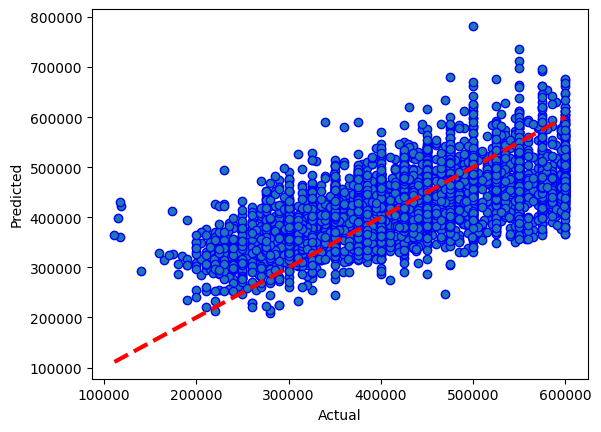

In [90]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(y_test, pipe.predict(X_test), edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')
#ax.title.set_text(f'CV Chosen best option ({calculated_best_pipe[1]})')
plt.show()

In [98]:
from datetime import datetime

results = {
    'Score': score,
    'R square Accuracy': R2,
    'Mean Absolute Error Accuracy': MAE,
    'Mean Squared Error Accuracy': MSE,
    'Root Mean Squared Error': RMSE,
    'Training Time': average_time,
    'random_state': RANDOM_STATE,
    'date': str(datetime.now()),
    'params': grid_result.best_params_
}
import json


def get_results():
    results_filename = '../../results/results.json'

    with open(results_filename) as f:
        raw_audit = f.read()
    results_json = json.loads(raw_audit)
    return results_json


def update_results(saved_results_json, new_results):
    key = f'{ALGORITHM} - {ALGORITHM_DETAIL} (v{VERSION})'.lower()
    try:
        first_run_date = str(datetime.now())
        first_run_date = saved_results_json[key]['date']
        first_run_date = saved_results_json[key]['first run']
    except:
        pass

    try:
        max_score = -1000
        max_params = 'NOT APPLICABLE'
        max_score = saved_results_json[key]['Score']
        max_params = saved_results_json[key]['params']
        max_score = saved_results_json[key]['max score']
        max_params = saved_results_json[key]['max params']
    except:
        pass

    results['first run'] = first_run_date
    if key not in saved_results_json:
        new_results['max params'] = new_results['params']
        new_results['max score'] = new_results['Score']
        new_results['suboptimal'] = 'pending'
    elif max_score > saved_results_json[key]['Score']:
        new_results['suboptimal'] = 'suboptimal'
    elif max_score == saved_results_json[key]['Score']:
        if saved_results_json[key]['params'] != new_results['params']:
            new_results['max params'] = 'MULTIPLE PARAM OPTIONS'
        else:
            new_results['max params'] = saved_results_json[key]['params']
            new_results['max score'] = saved_results_json[key]['Score']
            new_results['suboptimal'] = 'pending'
    else:
        new_results['max params'] = saved_results_json[key]['params']
        new_results['max score'] = saved_results_json[key]['Score']
        new_results['suboptimal'] = 'pending'

    saved_results_json[key] = new_results

    results_filename = '../../results/results.json'
    with open(results_filename, 'w') as file:
        file.write(json.dumps(saved_results_json, indent=4))


if not IN_COLAB:
    results_json = get_results()
    update_results(results_json, results)

results

{'Score': 0.4383177683788616,
 'R square Accuracy': 0.4383177683788616,
 'Mean Absolute Error Accuracy': 64693.873773454216,
 'Mean Squared Error Accuracy': 6344423918.004436,
 'Root Mean Squared Error': 79651.89211816902,
 'Training Time': 0.0567471981048584,
 'random_state': 101,
 'date': '2022-10-18 18:32:25.140893',
 'params': {'model__tol': 0.01,
  'model__solver': 'auto',
  'model__positive': False,
  'model__max_iter': 1000,
  'model__fit_intercept': True,
  'model__alpha': 1},
 'first run': '2022-10-18 18:32:17.850765',
 'max params': {'model__tol': 0.01,
  'model__solver': 'auto',
  'model__positive': False,
  'model__max_iter': 1000,
  'model__fit_intercept': True,
  'model__alpha': 1},
 'max score': 0.4383177683788616,
 'suboptimal': 'pending'}

In [103]:
deep_dive_csv = pd.read_csv(df_pathname_raw, index_col=0)

/tmp/ipykernel_5003/9682248.py:1: DtypeWarning: Columns (15,17,39,41,44,47,56,59,60,63,67,72,75,77,78,79) have mixed types. Specify dtype option on import or set low_memory=False.
  deep_dive_csv = pd.read_csv(df_pathname_raw, index_col=0)


In [104]:
deep_dive_csv.loc[125520530, ['Price', 'keyFeatures', 'sharedOwnership']]
deep_dive_csv.loc[85795281, ['Price', 'keyFeatures', 'sharedOwnership']]

deep_dive_csv.loc[85795281, 'text.description']


'25% or 100% share available. 100% price is £470,000. 25% is £117,500. ;;;;;;Lovely apartment with a private balcony in the Indescon Square development!The accommodation comprises a good size living/dining area benefitting fromwood flooring, a modern kitchen area, a deluxe white tiled bathroom and alsotwo double bedrooms. ;;; ;;;The location of this property provides elegantliving close to one of the world’s most popular business districts of CanaryWharf and an effortless journey from South Quay DLR to Bank makes employmentin the City of London just as accessible. South Quay, being a two-minute walkaway, provides easy access to Greenwich, an area which hosts an abundance ofbars and restaurants, along with a direct route to London City airport,Lewisham and Stratford to provide easy travel options beyond the capital. ;;;;;;Closer to home, ample bars and restaurants within close walking proximityto the property help to provide the area with a lively buzz and sense ofcommunity. ;;;Tenure: 

In [105]:
deep_dive_csv.loc[85795281]

Links                 https://www.rightmove.co.uk/properties/8579528...
Price                                                          117500.0
version                                                    v0021_300622
borough                                                   Tower Hamlets
referencing_link      https://www.rightmove.co.uk/property-for-sale/...
                                            ...                        
sharePercentage                                                   100.0
nearestStation                                                 0.189936
nearestTram                                                        99.0
nearestUnderground                                                 99.0
nearestOverground                                              0.189936
Name: 85795281, Length: 158, dtype: object

In [95]:
property_dataset = deep_dive_csv.loc[[125520530, 96587218], :]
property_dataset

(
        (property_dataset['sharedOwnership.sharedOwnership'] == True) |
        (property_dataset['analyticsProperty.priceQualifier'] == 'Shared ownership') |
        (property_dataset['keyFeatures'].str.contains('shared ownership'))
)

(property_dataset['keyFeatures'].str.contains('%'))

#(property_dataset['sharedOwnership'])
#'share' isin (property_dataset['keyFeatures'].str.lower())

#df[df.beer_style.str.contains('IPA')]
property_dataset[property_dataset.keyFeatures.str.contains('IPA')]

#(property_dataset['keyFeatures'].str.contains('%')))

,Links,Price,version,borough,referencing_link,add_info,date_scraped,version_listing,link,distance_to_any_train,...,Unnamed: 46,propertyType,coarse_compass_direction,sq_ft,sharedOwnership,sharePercentage,nearestStation,nearestTram,nearestUnderground,nearestOverground
